# <font color=#f06969>Evaluation of Synthetic Data</font>

## PRISM dataset evaluation from synthetic data generated on 03/09/2020
<hr>

The following jupyter notebook evaluates the distribution, fidelity and usefulness of the synthetic data synthesised for the PRISM dataset.<br>
The evaluation methods included are:
#### 1. Distribution evaluation methods:
[1.1 Numerical variables distribution comparison](#hist_link)
<br>[1.2 Categorical variables distribution comparison](#cat_link)
<br>[1.3 Pearson's Correlation Coefficient comparison](#pearsons_link)

#### 2. Fidelity evaluation methods:
[2.1 tSNE and PCA plots comparison](#tSNE_PCA_link)
<br>[2.2 Discriminative model performance](#discrim_link)
<br>[2.3 Autocorrelation comparison](#auto_link)

#### 3. Usefulness evaluation methods:
[3.1 Predictive model performance comparison](#pred_link)
<br>[3.2 Next-step predictive model performance comparison](#tpred_link)

<hr>

# <font color=#0275D8>Importing Packages</font>

In [1]:
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import pearsonr
import pandas as pd
import numpy as np

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

<hr>

# <font color=#0275D8>Data Loading and Preparation </font>

In [2]:
# specify numerical columns
num_cols = ['ab_pain_dur', 'age', 'aneroxia_dur', 'plasmodium_density',
               'cough_dur', 'diarrhea_dur', 'fatigue_dur', 'fever_dur', 'headache_dur',
               'height', 'hemoglobin', 'joint_pain_dur', 'muscle_ache_dur', 'temp',
               'vomit_dur', 'weight', 'dday', 'first_dday']

# specify categorical columns
cat_cols = ['complicated_malaria_no',
    'complicated_malaria_not_assessed', 'complicated_malaria_yes',
    'febrile_no', 'febrile_yes', 'ITN_no', 'ITN_not_applicable', 'ITN_yes',
    'malaria_no', 'malaria_yes',
    'malaria_parasite_blood_smear_indicated_but_not_done',
    'malaria_parasite_blood_smear_negative_/_lamp_negative',
    'malaria_parasite_blood_smear_negative_/_lamp_not_done',
    'malaria_parasite_blood_smear_negative_/_lamp_positive',
    'malaria_parasite_blood_smear_not_indicated',
    'malaria_parasite_blood_smear_positive_/_no_malaria',
    'malaria_parasite_symptomatic_malaria',
    'malaria_treatment_artmether-lumefantrine_for_uncomplicated_malaria',
    'malaria_treatment_no_malaria_medications_given',
    'malaria_treatment_quinine_for_uncomplicated_malaria_in_the_1st_trimester_of_pregnancy',
    'malaria_treatment_quinine_for_uncomplicated_malaria_within_14_days_of_a_previous_treatment_for_malaria',
    'malaria_treatment_quinine_or_artesunate_for_complicated_malaria',
    'plasmodium_gametocytes_no', 'plasmodium_gametocytes_yes',
    'plasmodium_lamp_negative', 'plasmodium_lamp_no_result',
    'plasmodium_lamp_positive', 'visit_type_enrollment',
    'visit_type_scheduled_visit', 'visit_type_unscheduled_visit']

def get_numerical_columns_df(df, num_cols=num_cols, return_id=False):
    """
    takes in dataframe with various columns and returns dataframe with only numerical columns
    ** to use with dataset other than prism dataset, please specify your own columns

    Args:
    df: dataframe converted from npy arrays generated by doppelganger
    num_cols: list of names of the numerical columns

    Returns:
    df_num: dataframe with only numerical columns
    """

    if return_id:
        num_cols = ['id'] + num_cols

    df_num = df[num_cols].copy()
    return df_num

def get_categorical_columns_df(df, cat_cols=cat_cols, return_id=False):
    """
    takes in dataframe with various columns and returns dataframe with only categorical columns
    ** to use with dataset other than prism dataset, please specify your own columns

    Args:
    df: dataframe converted from npy arrays generated by doppelganger
    cat_cols: list of names of the categorical columns

    Returns:
    df_num: dataframe with only categorical columns
    """

    if return_id:
        cat_cols = ['id'] + cat_cols
    df_cat = df[cat_cols].copy()
    return df_cat

In [6]:
def Stack2DSequence(df, time_seq_len=130):
    '''
    Transform a df in 2D shape into 3D by putting the data for the sampe patient ('id') in each layer, the 
    resulting shape is (no. of sample, max(time_sequence),dimension of column). If the time sequence length
    of this patient is less than the max(time_sequence), then post-pad remaining rows as zero.
    Args:
    df: dataframe with 'id' column as the first column
    time_seq_len = maximum time series length

    Returns:
    stacked_array: df reshaped into array of shape (num sample, time_seq_len, dim_columns)
    '''
    stacked_array = []
    id_unique = df.id.unique()

    for i in id_unique:
        child = np.array(df.loc[df['id'] == i].iloc[:, 1:])
        child = np.pad(child, ((0, time_seq_len-len(child)), (0,0)))
        stacked_array.append(child)
    stacked_array = np.stack(stacked_array)
    return stacked_array

In [7]:
# load in original and generated (intermediate) csv
ori = pd.read_csv('data_attr/ori_prism_cleaned.csv')
gen = pd.read_csv('data_attr/gen_prism_int_e200.csv')

# get numerical and categorical columns for original and generated data
ori_num = get_numerical_columns_df(ori)
gen_num = get_numerical_columns_df(gen)
ori_cat = get_categorical_columns_df(ori)
gen_cat = get_categorical_columns_df(gen)

# turn dataframe into 3D np arrays (both cat and num data)
ori_3d = Stack2DSequence(ori) #shape (1347,130,48)
gen_3d = Stack2DSequence(gen) #shape (1347,130,48)

# turn dataframe into 3D np arrays of only numerical or categorical data
ori_3d_num = Stack2DSequence(get_numerical_columns_df(ori, return_id=True))
gen_3d_num = Stack2DSequence(get_numerical_columns_df(gen, return_id=True))
ori_3d_cat = Stack2DSequence(get_categorical_columns_df(ori, return_id=True))
gen_3d_cat = Stack2DSequence(get_categorical_columns_df(gen, return_id=True))

In [8]:
# create a dictionary for the case where we want to loop through multiple sets of real and gen data
synthetic_data_dic = {'DoppelGANger_0903':[ori, gen]}
synthetic_num_dic = {'DoppelGANger_0903':[ori_num, gen_num]}
synthetic_cat_dic = {'DoppelGANger_0903':[ori_cat, gen_cat]}
synthetic_array_dic = {'DoppelGANger_0903':[ori_3d, gen_3d]}
synthetic_array_num_dic = {'DoppelGANger_0903':[ori_3d_num, gen_3d_num]}
synthetic_array_cat_dic = {'DoppelGANger_0903':[ori_3d_cat, gen_3d_cat]}
syn_keys = list(synthetic_data_dic.keys())
n = len(syn_keys)

<hr>

# <font color=#0275D8> 1. Distribution evaluation</font>

<a id = "hist_link" Here ></a>

## <font color=#472F91> 1.1 Numerical variables distribution comparison </font>

### <u> Method description </u>

For numerical columns, histograms for the original dataset and the generated dataset are overlaid for each column, giving a visual perception of the similarity in diversity and distribution.
To quantify this, a Kolmogrov-Smirnov Test is performed with 100 randomly selected samples to avoid biasing the result towards rejecting the null hypothesis. The Kolmogrov-Smirnov Test is a non parametric hypothesis test where the null hypothesis is that two samples (one from the original and one from the synthetic) originate from the same distribution.
<br><b>The closer the Kolmogrov-Smirnov Test p-value is to 1, the higher the fidelity</b>

In [9]:
def Histogram_KSTest(ori_nozero, gen_nozero, syn_name, size=100):
    """
    draws the pdf and cdf of numerical columns in original and generated data
    computes the KS Test value for ori and gen data
    K-S test result returns stats, p_value
    Ideally p_value should be as large as possible

    Args:
    ori_nonzero: original data with rows containing zeroes removed in dataframe format
    gen_nonzero: generated data with rows containing zeroes removed in dataframe format
    syn_name: version of synthetic data (used for labelling) e.g. 'doppelganger1'

    Returns:
    p_series: p_value for each numerical column in dataframe
    """
    keys = (ori_nozero.keys()).tolist()
    n = len(keys)
    l = min(len(ori_nozero),len(gen_nozero))
    
    p_value = np.zeros(n)
    for num in range(n):
        name = keys[num]
        ser_ori = ori_nozero[name].values[:l]
        ser_gen = gen_nozero[name].values[:l]
        df= pd.DataFrame({'ori':ser_ori, 'gen':ser_gen})
        df.plot.hist(bins=100,alpha=0.5,cumulative=False)
        plt.title(syn_name+' '+name+'_pdf')
        df.plot.hist(bins=100,alpha=0.5,cumulative=True,histtype='step')
        plt.title(syn_name+' '+name+'_cdf')
        plt.show()

        value = [0,0]
        for k in range(10):
        #Randomly take 100 samples from the generated and real data, since the total sample size is 40,000+, which is too
        #large and the null hypothesis can get easily rejected, which actually doesn't make statistical sense.
            idx = np.random.permutation(l)
            idx = idx[:size]
            name = keys[num]
            ser_ori = ori_nozero[name].values[idx]
            ser_gen = gen_nozero[name].values[idx]
            (t,p) = stats.ks_2samp(ser_ori, ser_gen)
            value[0] = value[0]+t
            value[1] = value[1]+p
        value = np.array(value)/10
        p_value[num] = value[1]
        print('K-S test result:',value) #the displayed array is the average (statistic, p_value), the closer to 0 the p is
        #the null hypothesis is more likely to be rejected.
    p_series = pd.Series(p_value, index = keys)
    return p_series

### <u> Results </u>

Overlays of original and generated histograms (probability density function) and corresponding cumulative distribution function for each column of the dataset.

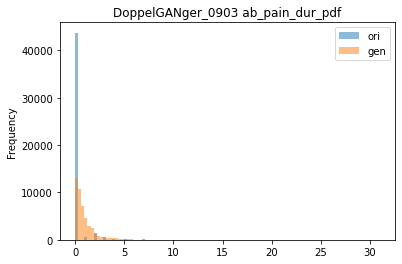

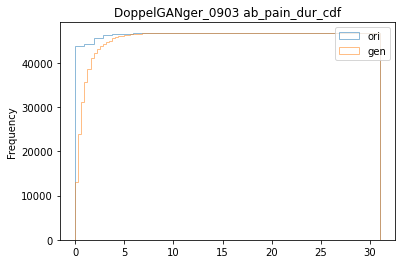

K-S test result: [9.29000000e-01 1.35400383e-41]


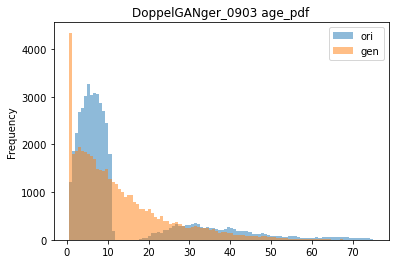

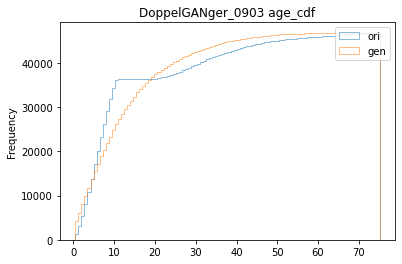

K-S test result: [0.238      0.08097225]


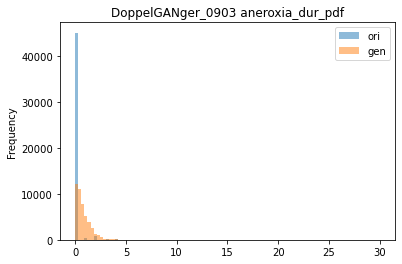

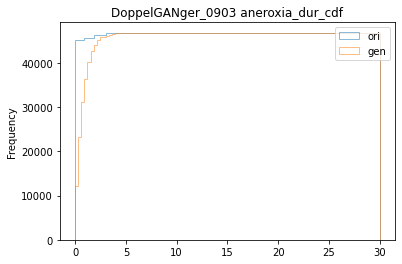

K-S test result: [9.53000000e-01 1.31795692e-46]


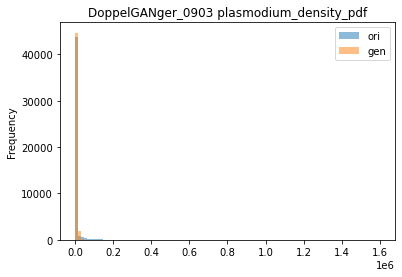

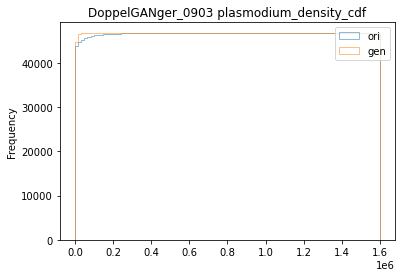

K-S test result: [8.31000000e-01 3.81569658e-32]


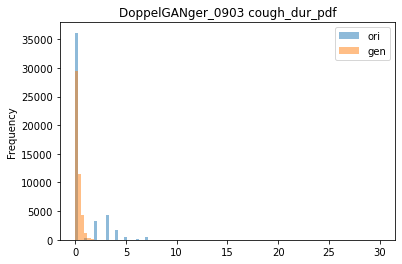

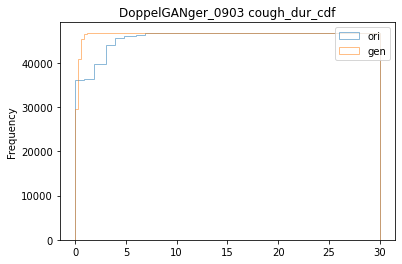

K-S test result: [4.88000000e-01 1.75485022e-07]


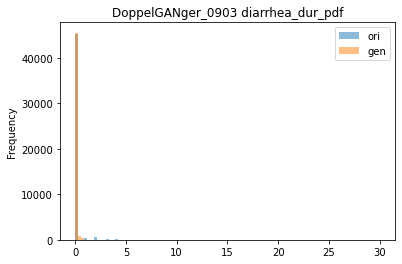

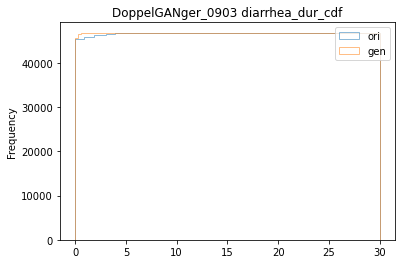

K-S test result: [5.43000000e-01 2.68051191e-12]


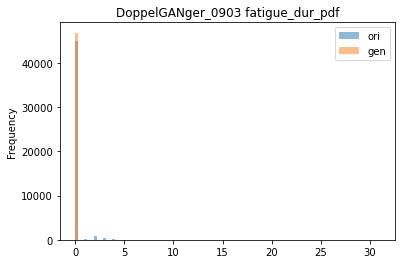

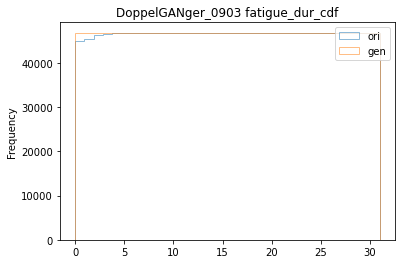

K-S test result: [8.83000000e-01 4.08745971e-37]


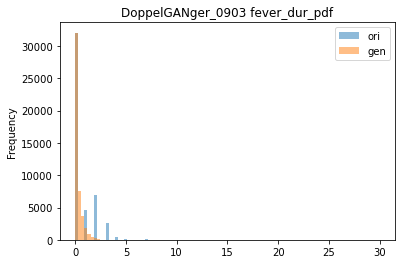

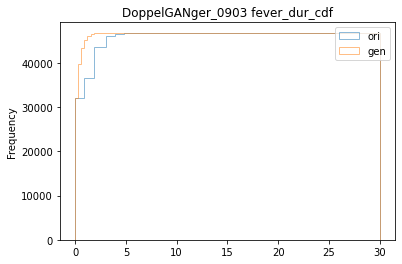

K-S test result: [3.28000000e-01 2.90025717e-04]


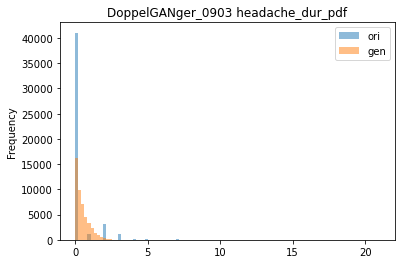

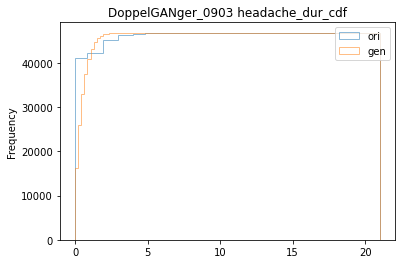

K-S test result: [8.77000000e-01 3.94189231e-34]


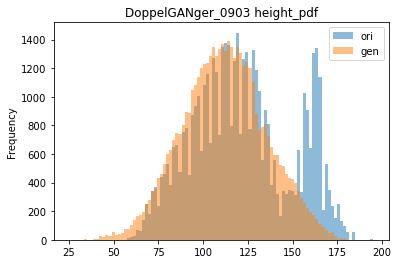

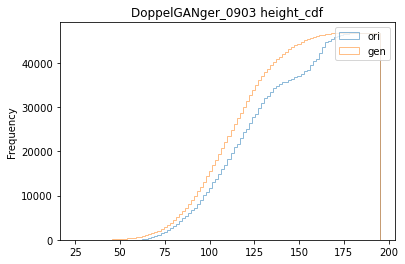

K-S test result: [0.183      0.18385055]


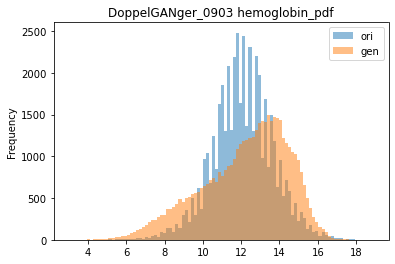

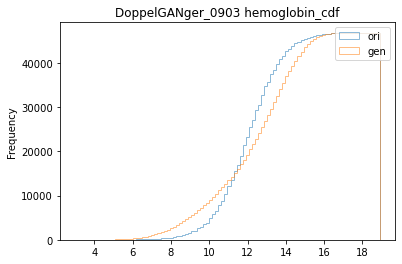

K-S test result: [0.207      0.06748389]


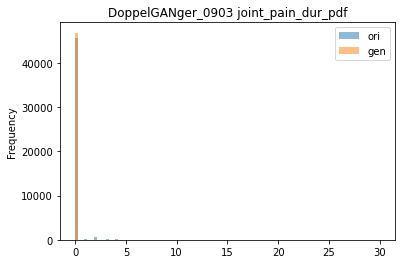

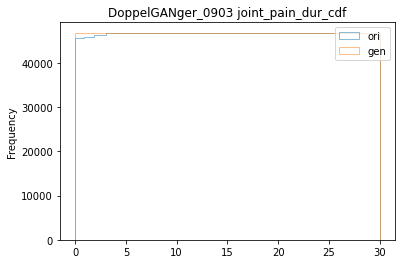

K-S test result: [0.016 1.   ]


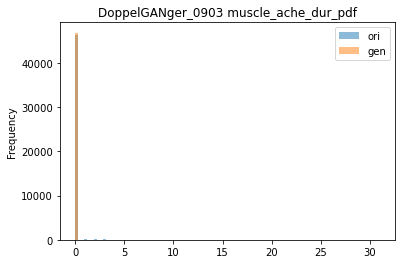

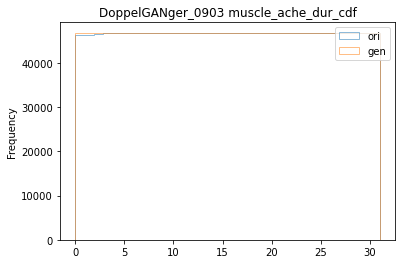

K-S test result: [0.014 1.   ]


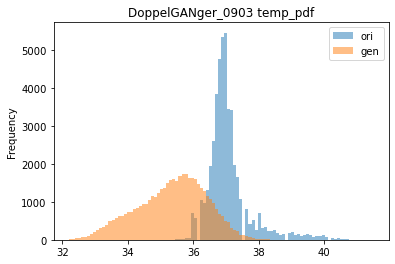

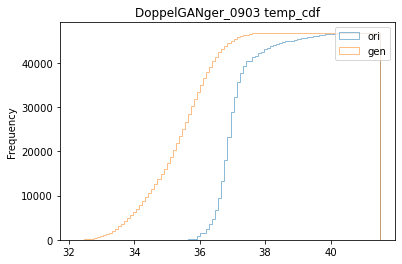

K-S test result: [7.66000000e-01 5.12548199e-24]


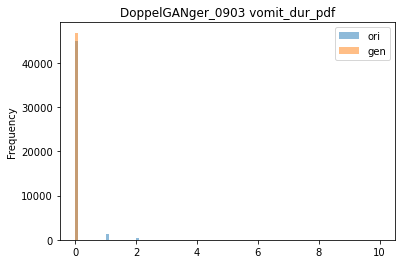

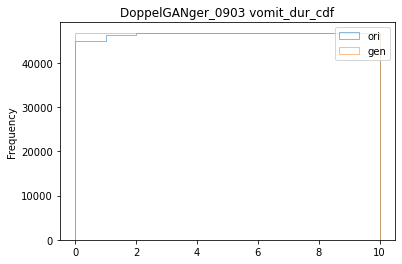

K-S test result: [0.076      0.87885525]


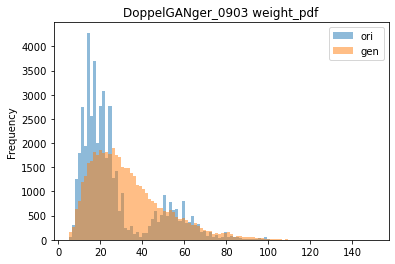

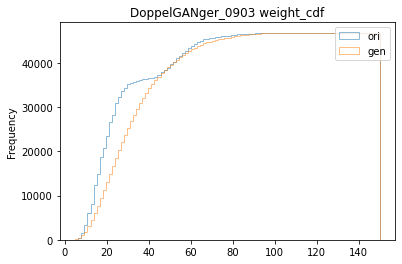

K-S test result: [0.325      0.00381079]


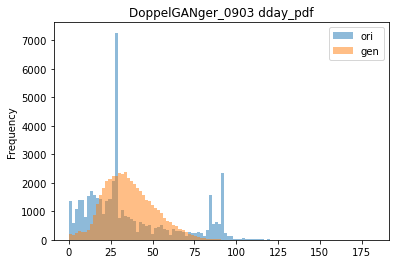

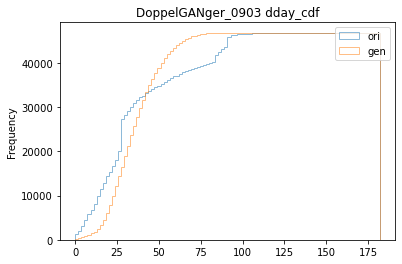

K-S test result: [0.248      0.01676422]


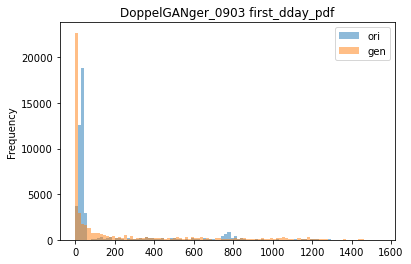

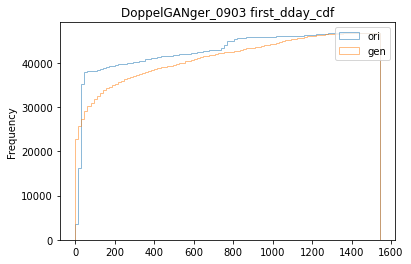

K-S test result: [4.09000000e-01 6.56755265e-06]


In [10]:
#Implement with all synthetic data and the corresponding real data.
for i in range(n):
    key = syn_keys[i]
    p_series = Histogram_KSTest(synthetic_num_dic[key][0],synthetic_num_dic[key][1],syn_name = key)
    if i == 0:
        p_df = pd.DataFrame(p_series,columns = [key])
    else:
        p_df = pd.concat([p_df,pd.DataFrame(p_series,columns = [key])],axis=1,sort = False)

### <u> Results cont. </u>

Table with p values of the Kolmogrov-Smirnov Test for each column, comparing the distribution of the original and the generated dataset. The closer to 1, the more similar the distribution of a column is between the original and the generated data.

In [11]:
pd.set_option('display.float_format', lambda x: '%.7f' % x)
#p_df.to_csv('csv_results/1.1 Distribution/p_value_table.csv')
display('Kolmogrov-Smirnov Test p value table',p_df)

'Kolmogrov-Smirnov Test p value table'

DoppelGANger_0903
ab_pain_dur                 0.0000000
age                         0.0809722
aneroxia_dur                0.0000000
plasmodium_density          0.0000000
cough_dur                   0.0000002
diarrhea_dur                0.0000000
fatigue_dur                 0.0000000
fever_dur                   0.0002900
headache_dur                0.0000000
height                      0.1838505
hemoglobin                  0.0674839
joint_pain_dur              1.0000000
muscle_ache_dur             1.0000000
temp                        0.0000000
vomit_dur                   0.8788552
weight                      0.0038108
dday                        0.0167642
first_dday                  0.0000066

### <u> Conclusions </u>

<a id = "cat_link" Here ></a>

## <font color=#472F91> 1.2 Categorical variables distribution comparison </font>

### <u> Method description </u>

For categorical columns, the empirical distribution of each variable for all categorical columns is calculated for the synthetic dataset and the original dataset.
A dot plot compares the empirical distribution of each variable for the original data set on the x axis and for the synthetic dataset on the y axis, giving a visual perception of the similarity in diversity and distribution. The closer the dot to the y=x line, the higher the fidelity.
<br><i>still deciding the best way to quantify</i>
<br>To quantify this, the distance of each coordinate to y=x is calculated.
<br><b>The lower the averaged distance, the higher the fidelity.</b>
<br>To quantifiy this, the MSE (mean standard error) between the empirical distribution for the original and synthetic dataset is calculated for each variable and averaged.
<br><b>The lower the averaged MSE, the higher the fidelity.</b>

In [17]:
# NOT USED NOW
def PtToDiagnalDist(coordinates, aver = True):
        '''
        For a series of points(2D), calculate the distance between each points and the diagonal y=x
        
        Args: 
        coordinates: array in shape (n,2), n is the number of points
        aver: True(default) or False. If aver == True, the distances are averaged, otherwise a list of distances is returned
        
        Returns:
        a: a list of distances, returned when aver==False
        np.sum(a)/n: the average of distances, returned when aver == True
        '''
        n = len(coordinates)
        a = np.zeros(n)
        for i in range(n):
            x = coordinates[i][0]
            y = coordinates[i][1]
            d = abs(x-y)/sqrt(2) #formula to calculate the distance between point (X,Y) and line ax+by+c = 0 is
            # abs(aX+bY+c)/abs(a^2+b^2)
            a[i]=d
        if aver:
            return np.sum(a)/n
        else:
            return a

In [20]:
def Scatter_Distance(ori_data, gen_data, syn_name = None):
    """
    Plots the proportion of 1s and 0s in each categorical column in the synthetic data against the real data.
    An ideal synthetic data should lie on the diagonal y=x.
    Calculates the average distance of points plotted to the line y=x.
    The smaller the average distance, the better.

    Args:
    ori_data: original data with only categorical columns in dataframe format
    gen_data: generated data with only categorical columns in dataframe format
    syn_name: version of synthetic data (used for labelling) e.g. 'doppelganger

    Returns:
    distance: average distance of points plotted to line y=x
    """

    import matplotlib.pyplot as plt
    from math import sqrt
    
    def CatProportion(series):
        return series.value_counts()/len(series)

    cat_keys = (gen_data.keys()).tolist()
    first = True
    name_index = []
    cat_index = []
    for name in cat_keys:
        df_1=pd.DataFrame({'gen':1 - CatProportion(gen_data[name])[0],'ori': 1 - CatProportion(ori_data[name])[0]}, index=["True"])
        if first:
            v = df_1.values
            first = False
        else:
            v = np.concatenate((v,df_1.values),axis = 0)
        df1_index = df_1.index.tolist()
        name_index += [name]*len(df1_index)
        cat_index += df1_index
    
    df_cat = pd.DataFrame(v, index = [name_index,cat_index], columns = [syn_name+ ' '+'generated',syn_name+' '+'original'])
    df_cat = df_cat.fillna(0)
    display(df_cat)
    #df_cat.to_csv('csv_results/1.1 Distribution/ '+syn_name+'categorical scatter.csv')
    plt.scatter(df_cat[syn_name+ ' '+'generated'],df_cat[syn_name+' '+'original'],c = 'r')
    plt.plot([0,1])
    plt.xlabel('Generated Categorical values')
    plt.ylabel('Original Categorical values')
    plt.show()
    
    distance = mean_squared_error(df_cat.values[:, 0], df_cat.values[:, 1])
    
    return distance

### <u> Results </u>

A Table displaying the empirical distributions for each unique variable for each categorical column. The generated values are plotted on the x axis and compared to the original values on the y axis on the scatter plot.

DoppelGANger_0903 generated  \
complicated_malaria_no                             True                    0.0212429   
complicated_malaria_not_assessed                   True                    0.9787571   
complicated_malaria_yes                            True                    0.0000000   
febrile_no                                         True                    0.7887032   
febrile_yes                                        True                    0.2112968   
ITN_no                                             True                    0.0000000   
ITN_not_applicable                                 True                    0.0287870   
ITN_yes                                            True                    0.9712130   
malaria_no                                         True                    0.9772183   
malaria_yes                                        True                    0.0227817   
malaria_parasite_blood_smear_indicated_but_not_... True                    0.0000000   
malaria_parasite_blood_smear_negative_/_lamp_ne... True                    0.4932681   
malaria_parasite_blood_smear_negative_/_lamp_no... True                    0.3392033   
malaria_parasite_blood_smear_negative_/_lamp_po... True                    0.0206446   
malaria_parasite_blood_smear_not_indicated         True                    0.0307531   
malaria_parasite_blood_smear_positive_/_no_malaria True                    0.0021585   
malaria_parasite_symptomatic_malaria               True                    0.1139725   
malaria_treatment_artmether-lumefantrine_for_un... True                    0.0235083   
malaria_treatment_no_malaria_medications_given     True                    0.9764917   
malaria_treatment_quinine_for_uncomplicated_mal... True                    0.0000000   
malaria_treatment_quinine_for_uncomplicated_mal... True                    0.0000000   
malaria_treatment_quinine_or_artesunate_for_com... True                    0.0000000   
plasmodium_gametocytes_no                          True                    0.9999359   
plasmodium_gametocytes_yes                         True                    0.0000641   
plasmodium_lamp_negative                           True                    0.3567490   
plasmodium_lamp_no_result                          True                    0.6323944   
plasmodium_lamp_positive                           True                    0.0108566   
visit_type_enrollment                              True                    0.0287870   
visit_type_scheduled_visit                         True                    0.6061293   
visit_type_unscheduled_visit                       True                    0.3650838   

                                                         DoppelGANger_0903 original  
complicated_malaria_no                             True                   0.1220322  
complicated_malaria_not_assessed                   True                   0.8762160  
complicated_malaria_yes                            True                   0.0017519  
febrile_no                                         True                   0.6865829  
febrile_yes                                        True                   0.3134171  
ITN_no                                             True                   0.0017312  
ITN_not_applicable                                 True                   0.0277617  
ITN_yes                                            True                   0.9705070  
malaria_no                                         True                   0.8762160  
malaria_yes                                        True                   0.1237840  
malaria_parasite_blood_smear_indicated_but_not_... True                   0.0000412  
malaria_parasite_blood_smear_negative_/_lamp_ne... True                   0.3664262  
malaria_parasite_blood_smear_negative_/_lamp_no... True                   0.2301525  
malaria_parasite_blood_smear_negative_/_lamp_po... True                   0.0934872  
malaria_parasite_blood_smear_not_indic

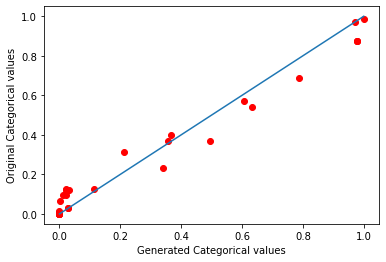

'average MSE of ori and gen data'

DoppelGANger_0903   0.0048382
dtype: float64

In [21]:
#Implement with all synthetic data and the corresponding real data.
d_array = np.zeros(n)
for i in range(n):
    key = syn_keys[i]
    distance = Scatter_Distance(synthetic_cat_dic[key][0],synthetic_cat_dic[key][1],syn_name = key)
    d_array[i] = distance
distance_series= pd.Series(d_array,index = syn_keys)
#distance_series.to_csv('csv_results/1.1 Distribution/aver_distance_to_the_diag.csv')
display('average MSE of ori and gen data', distance_series)

### <u> Conclusions </u>

<a id = "pearsons_link" Here ></a>

## <font color=#472F91> 1.3 Pearson's Correlation Coefficient Comparison </font>

### <u> Method description </u>

To confirm dependencies between variables within columns are maintained, Pearson’s R correlation coefficient is calculated between categorical (all?) columns within the original and synthetic data.
<br>To compare the datasets, we use two measurements. Firstly, the MSE (mean standard error) is calculated between each correlation coefficient.
<br><b>The lower the MSE, the higher the fidelity.</b>
<br>Secondly, the SRA (Synthetic Ranking Accuracy) for each column is calculated. Here, the R correlation coefficients for the remaining columns are ranked for both the synthetic and the original data and compared.
<br><b>The closer SRA is to 1 the higher the fidelity.</b>

In [22]:
def r_corr_test(df,PTable = False, CoefficientandPtable = False, lower = True ):
    '''Returns a table of Pearson's r correlation coefficients between every pair of columns in the dataframe
    
    Args:
    df: The input dataframe
    PTable: False (default) or True, if True, then the return is a table containing the p(probavility)-value of correlation test.
    CoefficientandPtable: False(default) or True, if true, then the return is a table containing tuples (p-value, r coefficient) from the correlation test.
    lower: True(default) or False. If True, the lower triangle part of the table is filled with the transpose of the upper triangle part rather than leaved with None.
    
    Returns:
    The requested table as specified in the args. If PTable and CoefficientandPtable are all False, then the return table consists of coefficient values only.
    
    '''

    df_index = (df.keys()).tolist()
    n = len(df_index)
    ini = [ [ None for y in range( n ) ] 
                 for x in range( n ) ]

    #pearsonr returns two values: the correlation coefficient and significance test probability p
    #so we create two empty dataframes to store them
    coefficient_table = pd.DataFrame(ini,index = df_index,columns = df_index)
    p_table = coefficient_table.copy()
    coe_and_p_table = coefficient_table.copy()

    for i in range(n):
        for j in range(i+1,n):
            name1 = df_index[i]
            name2 = df_index[j]
            obs_1 = df[name1].dropna()
            obs_2 = df[name2].dropna()
            dataframe = pd.DataFrame({name1: obs_1, name2: obs_2})

            values = dataframe.dropna().values
            (coe,p) = pearsonr(values[:,0],values[:,1])
            coefficient_table.loc[name1,name2]=coe
            p_table.loc[name1,name2]=p
            coe_and_p_table.loc[name1,name2]=(coe,p)
    
    if lower:
        #A function that can fill the lower part of the dataframe, because coe_table and p_table has their lower triangles empty
        #But for comparison reasons you may want them to be filled
        def fill_lower(df):
            n = df.values.shape[0]
            for j in range(n):
                for i in range(j+1,n):
                    df.iloc[i,j]=df.iloc[j,i]
            return df
        
        coefficient_table = fill_lower(coefficient_table)
        p_table = fill_lower(p_table)
        coe_and_p_table = fill_lower(coe_and_p_table)
    
    
    if PTable:
        return p_table
    elif CoefficientandPtable:
        return coe_and_p_table
    else:
        return coefficient_table

In [23]:
def SRA(R,S):
    '''Calculate the SRA of lists R and S
    
    Args:
    - R: A list of performance metrics of different predictive models from TSTS
    - S: A list of performance metrics of different predictive models from TRTR, len(S)=len(R)
    
    Returns:
    - SRA: SRA value
    
    '''
    def identity_function(statement):
        v = 0
        if statement:
            v = 1
        return v
            
    k = min(len(R), len(S)) #technically should be same
    sum_ = 0
    for i in range(k):
        for j in range(k):
            if i != j:
                if (R[i]-R[j])==0:
                    if (S[i]-S[j])==0:
                        agree = True
                    else:
                        agree = False
                else:
                    agree = (R[i]-R[j])*(S[i]-S[j])>0
                sum_ += identity_function(agree)
    SRA = sum_ / (k*(k-1))
    return SRA

In [24]:
def CorrelationSRA(ori_correlation_df,gen_correlation_df,ColumnWise = False):
    '''Returns the value of SRA for the absolute Pearsons correlation coefficients for each column between 
    all other columns. SRA is between 0 and 1, the closer the SRA is to 1, the more the agreement between the ranking,
    the more similar the synthetic data and the real data are.
    
    Args:
    ori_correlation_df: the correlation coefficient dataframe for the real data, usually generated from the function 
                        r_corr_test.
    gen_correlation_df: the correlation coefficient dataframe for the synthetic data, usually generated from the function 
                        r_corr_test. 
    ColumnWise: False(default) or True. If True, the return is a Series containing the SRA value for each column and the average.
                Otherwise, the return is the average of SRA values for all columns
    
    Returns:
    s: It is either a column-wise SRA series or the average SRA values of them, determined by the arg ColumnWise.
    
    '''
    
    columns = (ori_correlation_df.keys()).tolist()
    n = len(columns)
    ini = np.ones(n)
    
    for i in range(n):
        ori_values = ori_correlation_df.iloc[i,:].fillna(-1)
        gen_values = gen_correlation_df.iloc[i,:].fillna(-1) #quick fix when len(R) != len(S) due to a particular column having all zeroes, hence r_corr_test returns NAN values, the fillna above was originally dropna(), resulting that column to be dropped and creating trouble in CorrelationSRA as len(R) != len(S) anymore, hence index out of bound when looping
        ini[i] = SRA(abs(ori_values), abs(gen_values))
    
    if ColumnWise:
        s = pd.Series(ini,index = columns)
        s['AVERAGE'] = sum(ini)/n
    else:
        s = sum(ini)/n
    return s

In [25]:
def MSE(r_table_ori,r_table_gen):
    '''
    Returns the MSE for each position between two dataframes and an average value.
    '''
    import pandas as pd
    import numpy as np
    ori = r_table_ori.fillna(0).values
    gen = r_table_gen.fillna(0).values
    columns = (r_table_gen.keys()).tolist()
    matrix = (ori-gen)**2
    df = pd.DataFrame(matrix, index = columns, columns = columns)
    score = np.sum(matrix)/(len(ori)*(len(ori)-1)) #The diagonal is always zero so we don't count them
    return df, score

### <u> Results </u>

Two tables are displayed with the R correlation coefficient between all columns, for the original and for the generated data. For high level of correlation with an R > 0.5, the cell is coloured yellow. The third table includes the SRA (Synthetic Ranking Accuracy) for each column where it's R correlation coefficients with the remaining columns are ranked for both the synthetic and the original data and compared. The fourth table displays the MSE's between the R correlation coefficients between the original and the generated data, displaying the result for each column.

In [26]:
n = len(syn_keys)
MSE_array = np.zeros(n)
for i in range(n):
    key = syn_keys[i]
    df_ori = synthetic_data_dic[key][0]
    df_gen = synthetic_data_dic[key][1]
    r_table_ori = r_corr_test(df_ori)
    r_table_gen = r_corr_test(df_gen)
    
    #Highlight all r values > 0.5 as yellow, indicating strong correlation
    def color_threshold_yellow(val):
        threshold = 0.5
        if ((val != None) and (abs(val) > threshold)):
            color = 'yellow' 
        else:
            color = 'black'
        return 'color: %s' % color

    display(key+' '+'generated r table',r_table_gen.style.applymap(color_threshold_yellow))
    display(key+' '+'real r table',r_table_ori.style.applymap(color_threshold_yellow))
    sra = CorrelationSRA(r_table_ori,r_table_gen,ColumnWise=True)
    if i==0:
        sra_df = pd.DataFrame(sra,columns = [key])
    else:
        sra_df = pd.concat([sra_df,pd.DataFrame(sra,columns = [key])], axis = 1, sort = False)
    display(key+' '+'SRA',sra)
    MSE_df, MSE_score = MSE(r_table_gen,r_table_ori)
    display(key+' '+'MSE table', MSE_df)
    MSE_array[i] = MSE_score
MSE_series = pd.Series(MSE_array,index = syn_keys)

'DoppelGANger_0903 generated r table'

'DoppelGANger_0903 real r table'

'DoppelGANger_0903 SRA'

id                                                                                                       0.3894558
ab_pain_dur                                                                                              0.4515306
age                                                                                                      0.5680272
aneroxia_dur                                                                                             0.4795918
plasmodium_density                                                                                       0.4727891
cough_dur                                                                                                0.5102041
diarrhea_dur                                                                                             0.3962585
fatigue_dur                                                                                              0.4863946
fever_dur                                                                       

'DoppelGANger_0903 MSE table'

id  ab_pain_dur  \
id                                                 0.0000000    0.0000429   
ab_pain_dur                                        0.0000429    0.0000000   
age                                                0.0002264    0.0128281   
aneroxia_dur                                       0.0094825    0.0000349   
plasmodium_density                                 0.0000213    0.0840074   
cough_dur                                          0.0126800    0.0686624   
diarrhea_dur                                       0.0204755    0.1145833   
fatigue_dur                                        0.0001130    0.0005085   
fever_dur                                          0.0142094    0.0927941   
headache_dur                                       0.0000266    0.0013007   
height                                             0.0088373    0.0149329   
hemoglobin                                         0.0101860    0.0157665   
joint_pain_dur                                     0.0000058    0.0077327   
muscle_ache_dur                                    0.0003981    0.0081973   
temp                                               0.0018350    0.0011041   
vomit_dur                                          0.0033010    0.0323774   
weight                                             0.0126108    0.0113114   
complicated_malaria_no                             0.0108234    0.0026348   
complicated_malaria_not_assessed                   0.0104937    0.0025705   
complicated_malaria_yes                            0.0000603    0.0000110   
febrile_no                                         0.0083341    0.0093812   
febrile_yes                                        0.0083341    0.0093812   
ITN_no                                             0.0000697    0.0000192   
ITN_not_applicable                                 0.0016525    0.0000741   
ITN_yes                                            0.0017269    0.0000473   
malaria_no                                         0.0106387    0.0024897   
malaria_yes                                        0.0106387    0.0024897   
malaria_parasite_blood_smear_indicated_but_not_... 0.0000064    0.0000015   
malaria_parasite_blood_smear_negative_/_lamp_ne... 0.0114303    0.0144193   
malaria_parasite_blood_smear_negative_/_lamp_no... 0.0039730    0.0008862   
malaria_parasite_blood_smear_negative_/_lamp_po... 0.0071665    0.0012594   
malaria_parasite_blood_smear_not_indicated         0.0001514    0.0297427   
malaria_parasite_blood_smear_positive_/_no_malaria 0.0087814    0.0023385   
malaria_parasite_symptomatic_malaria               0.0096930    0.0025131   
malaria_treatment_artmether-lumefantrine_for_un... 0.0096716    0.0027244   
malaria_treatment_no_malaria_medications_given     0.0094416    0.0027315   
malaria_treatment_quinine_for_uncomplicated_mal... 0.0000023    0.0001300   
malaria_treatment_quinine_for_uncomplicated_mal... 0.0000939    0.0000160   
malaria_treatment_quinine_or_artesunate_for_com... 0.0000603    0.0000110   
plasmodium_gametocytes_no                          0.0014053    0.0005341   
plasmodium_gametocytes_yes                         0.0014053    0.0005341   
plasmodium_lamp_negative                           0.0120349    0.0101118   
plasmodium_lamp_no_result                          0.0029840    0.0145776   
plasmodium_lamp_positive                           0.0074716    0.0011706   
visit_type_enrollment                              0.0016525    0.0000741   
visit_type_scheduled_visit                         0.0023388    0.0322637   
visit_type_unscheduled_visit                       0.0039052    0.0338984   
dday                                               0.0651535    0.0031129   
first_dday                                         0.0285740    0.0186011   

                                                         age  aneroxia_dur  \
id                                                 0.0002264     0.0094825   
ab_pain_dur                                        

In [27]:
display('MSE values of r for each synthetic data',MSE_series)

'MSE values of r for each synthetic data'

DoppelGANger_0903   0.0251338
dtype: float64

In [28]:
display('SRA for each column and synthetic data',sra_df)

'SRA for each column and synthetic data'

DoppelGANger_0903
id                                                          0.3894558
ab_pain_dur                                                 0.4515306
age                                                         0.5680272
aneroxia_dur                                                0.4795918
plasmodium_density                                          0.4727891
cough_dur                                                   0.5102041
diarrhea_dur                                                0.3962585
fatigue_dur                                                 0.4863946
fever_dur                                                   0.4404762
headache_dur                                                0.4183673
height                                                      0.6215986
hemoglobin                                                  0.5697279
joint_pain_dur                                              0.0076531
muscle_ache_dur                                             0.0076531
temp                                                        0.5408163
vomit_dur                                                   0.4540816
weight                                                      0.5612245
complicated_malaria_no                                      0.5748299
complicated_malaria_not_assessed                            0.5892857
complicated_malaria_yes                                     0.0119048
febrile_no                                                  0.5518707
febrile_yes                                                 0.5518707
ITN_no                                                      0.0076531
ITN_not_applicable                                          0.5442177
ITN_yes                                                     0.5756803
malaria_no                                                  0.5858844
malaria_yes                                                 0.5841837
malaria_parasite_blood_smear_indicated_but_not_...          0.0076531
malaria_parasite_blood_smear_negative_/_lamp_ne...          0.5773810
malaria_parasite_blood_smear_negative_/_lamp_no...          0.5765306
malaria_parasite_blood_smear_negative_/_lamp_po...          0.5416667
malaria_parasite_blood_smear_not_indicated                  0.5586735
malaria_parasite_blood_smear_positive_/_no_malaria          0.4064626
malaria_parasite_symptomatic_malaria                        0.5926871
malaria_treatment_artmether-lumefantrine_for_un...          0.5518707
malaria_treatment_no_malaria_medications_given              0.5790816
malaria_treatment_quinine_for_uncomplicated_mal...          0.0127551
malaria_treatment_quinine_for_uncomplicated_mal...          0.0127551
malaria_treatment_quinine_or_artesunate_for_com...          0.0119048
plasmodium_gametocytes_no                                   0.4438776
plasmodium_gametocytes_yes                                  0.4447279
plasmodium_lamp_negative                                    0.5323129
plasmodium_lamp_no_result                                   0.5595238
plasmodium_lamp_positive                                    0.5127551
visit_type_enrollment                                       0.5442177
visit_type_scheduled_visit                                  0.5459184
visit_type_unscheduled_visit                                0.5365646
dday                                                        0.5331633
first_dday                                                  0.4965986
AVERAGE                                                     0.4394350

### <u> Conclusions </u>

<hr>

# <font color=#0275D8> 2. Fidelity Evaluation </font>

<a id = "tSNE_PCA_link" Here ></a>

## <font color=#472F91> 2.1 tSNE and PCA plots comparison </font>

### <u> Method description </u>

tSNE and PCA plots reduce a multi-dimensional dataset (i.e with multiple columns) into a 2-dimensional visualisation. 
<br>A machine-learning algorithm groups similar variables and although we cannot interpret the coordinates attributed, we can compare if the groupings made are similar in the original and synthetic data by overlaying the plots.
<br><b>The higher the overlay, the higher the fidelity.</b>

In [29]:
def visualization (ori_data, generated_data, analysis,syn_name):
    """Using PCA or tSNE for generated and original data visualization.
    (Originally from tGAN code, updated by Aisha to allow ori_data and generated_data to have different time_sequence_length)

    Args:
    - ori_data: original data
    - generated_data: generated synthetic data
    - analysis: tsne or pca
    - syn_name: the name of the synthetic generator
    """  
    # Analysis sample size (for faster computation)
    anal_sample_no = min([1000, len(ori_data),len(generated_data)])
    idx = np.random.permutation(len(ori_data))[:anal_sample_no]

    # Data preprocessing
    ori_data = np.asarray(ori_data)
    generated_data = np.asarray(generated_data)  

    ori_data = ori_data[idx]
    generated_data = generated_data[idx]

    def SameTimeSeq(ori_data,gen_data):
        #make time_seq_o and time_seq_g of a pair of ori_df and gen_df the same to get tSNE and PCA work; we achieve this
        #by padding zeros to the shorter time_seq df.
        no_o, time_seq_o, d = ori_data.shape
        no_g, time_seq_g, d = gen_data.shape
        time_seq = max(time_seq_o,time_seq_g)
        if time_seq_o != time_seq_g:
            if time_seq_g < time_seq_o:
                padding = np.zeros((no_g,time_seq_o-time_seq_g,d))
                gen_data = np.concatenate((gen_data,padding),axis = 1)
            else:
                padding = np.zeros((no_o,time_seq_g-time_seq_o,d))
                ori_data = np.concatenate((ori_data,padding),axis = 1)
        return ori_data,gen_data,time_seq

    ori_data, generated_data, seq_len = SameTimeSeq(ori_data, generated_data)

    for i in range(anal_sample_no):
        if (i == 0):
          prep_data = np.reshape(np.mean(ori_data[0,:,:], 1), [1,seq_len])
          prep_data_hat = np.reshape(np.mean(generated_data[0,:,:],1), [1,seq_len])
        else:
          prep_data = np.concatenate((prep_data, 
                                      np.reshape(np.mean(ori_data[i,:,:],1), [1,seq_len])))
          prep_data_hat = np.concatenate((prep_data_hat, 
                                          np.reshape(np.mean(generated_data[i,:,:],1), [1,seq_len])))

    # Visualization parameter        
    colors = ["red" for i in range(anal_sample_no)] + ["blue" for i in range(anal_sample_no)]    

    if analysis == 'pca':
        # PCA Analysis
        pca = PCA(n_components = 2)
        pca.fit(prep_data)
        pca_results = pca.transform(prep_data) #PCA coordinates for the real data
        pca_hat_results = pca.transform(prep_data_hat) #PCA coordinates for the synthetic data

        # Plotting
        f, ax = plt.subplots(1)    
        plt.scatter(pca_results[:,0], pca_results[:,1],
                    c = colors[:anal_sample_no], alpha = 0.2, label = "Original")
        plt.scatter(pca_hat_results[:,0], pca_hat_results[:,1], 
                    c = colors[anal_sample_no:], alpha = 0.2, label = "Generated")

        ax.legend()  
        plt.title(syn_name+' '+'PCA plot')
        plt.xlabel('x-pca')
        plt.ylabel('y-pca')
        #plt.savefig('png_files/2.1 tsne/'+syn_name+'_pca'+'.png')
        plt.show()
        
        return pca_results, pca_hat_results

    elif analysis == 'tsne':

        # Do t-SNE Analysis together       
        prep_data_final = np.concatenate((prep_data, prep_data_hat), axis = 0)

        # TSNE anlaysis
        tsne = TSNE(n_components = 2, verbose = 1, perplexity = 40, n_iter = 300)
        tsne_results = tsne.fit_transform(prep_data_final) #tSNE coordinates, 
        #for [:anal_sample_no, : ] are the coordinates for the original,
        #for [anal_sample_no: , : ] are the coordinates for the generated

        # Plotting
        f, ax = plt.subplots(1)

        plt.scatter(tsne_results[:anal_sample_no,0], tsne_results[:anal_sample_no,1], 
                    c = colors[:anal_sample_no], alpha = 0.2, label = "Original")
        plt.scatter(tsne_results[anal_sample_no:,0], tsne_results[anal_sample_no:,1], 
                    c = colors[anal_sample_no:], alpha = 0.2, label = "Generated")

        ax.legend()

        plt.title(syn_name+' '+'t-SNE plot')
        plt.xlabel('x-tsne')
        plt.ylabel('y-tsne')
        #plt.savefig('png_files/2.1 tsne/'+syn_name+'_tsne'+'.png')
        plt.show()
        
        return tsne_results[:anal_sample_no, :], tsne_results[anal_sample_no:,:]

In [ ]:
#exporting coordinates
# dp_pca_np = np.concatenate([dp_pca_results, dp_pca_hat_results], axis = 1)
# dp_pca_df = pd.DataFrame(dp_pca_np, columns = ['real_x', 'real_y', 'gen_x', 'gen_y'])
# dp_pca_df.to_csv('pca_coordinates.csv', index=False)

# dp_tsne_np = np.concatenate([dp_tsne_results, dp_tsne_hat_results], axis = 1)
# dp_tsne_df = pd.DataFrame(dp_tsne_np, columns = ['real_x', 'real_y', 'gen_x', 'gen_y'])
# dp_tsne_df.to_csv('tsne_coordinates.csv', index=False)

### <u> Results </u>

tSNE and PCA plot overlays for original and generated data

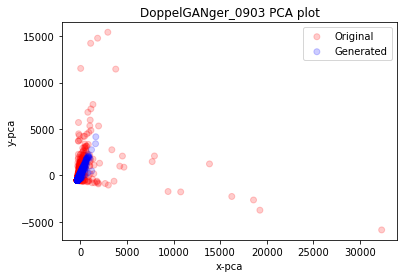

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.117s...
[t-SNE] Computed neighbors for 2000 samples in 1.368s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 15.820768
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.956398
[t-SNE] KL divergence after 300 iterations: 1.002141


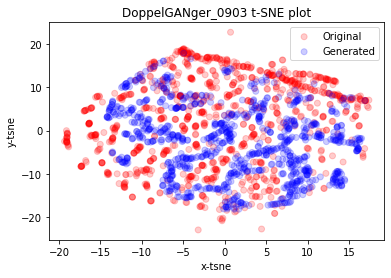

In [30]:
for i in range(n):
    key = syn_keys[i]
    visualization(synthetic_array_dic[key][0], synthetic_array_dic[key][1], 'pca',syn_name = key)
    visualization(synthetic_array_dic[key][0], synthetic_array_dic[key][1], 'tsne',syn_name = key)

### <u> Conclusions </u>

<a id = "discrim_link" Here ></a>

## <font color=#472F91> 2.2 Discriminative model performance </font>

### <u> Model Description </u>
For a quantitative measure of similarity, a post-hoc time-series classification model is trained (by optimizing a multi-layer GRU) to distinguish between sequences from the original and generated datasets.
First, each original sequence is labeled '1', and each generated sequence is labeled '0'.
<br>Then, an off-the-shelf (RNN) classifier is trained to distinguish between the two classes as a standard supervised task.
<br>An accuracy score on the held-out test set gives a quantitative assessment of fidelity.
<br><b>An accuracy score similar to the expected accuracy score for an untrained discriminative model indicates the discriminator cannot tell the difference between both datasets.</b>

In [18]:
# Split into train, val, test set
def train_val_test_split(ori_data, gen_data, frac=(0.65, 0.2, 0.15)): 

  data = np.concatenate([ori_data,gen_data],axis=0)
  labels = np.concatenate([np.ones(len(ori_data)), np.zeros(len(gen_data))], axis=0)

  train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=frac[2])
  train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, train_size=frac[0]/(frac[0]+frac[1]))
  return train_data, val_data, test_data, train_labels, val_labels, test_labels

In [19]:
# define discriminative model
def discriminative_model(input_size, hidden_dim): 

    inputs = tf.keras.Input(shape = input_size)
    GRU_output_sequence, GRU_last_state = tf.keras.layers.GRU(hidden_dim, return_sequences = True, return_state = True)(inputs)
    Dense1 = tf.keras.layers.Dense(hidden_dim)(GRU_last_state)
    Dense2 = tf.keras.layers.Dense(1, activation='sigmoid')(Dense1)
    
    model = tf.keras.Model(inputs = inputs, outputs = [Dense2])
    model.compile(optimizer = "adam", loss = tf.keras.losses.BinaryCrossentropy())
    
    return model

### <u> Results </u>

A table with the report is displayed together with the expected accuracy and the obtained accuracy. The more similar these two values are, the better the fidelity of the generated data towards the original data.

In [20]:
for i in range(n):
    key = syn_keys[i]

    # train discriminative model
    train_data, val_data, test_data, train_labels, val_labels, test_labels = train_val_test_split(ori_data=synthetic_array_num_dic[key][0], gen_data=synthetic_array_num_dic[key][0])

    input_dim = np.asarray(synthetic_array_num_dic[key][0]).shape[2]
    d_model = discriminative_model(input_size=[None, input_dim], hidden_dim=64)

    history_d_model = d_model.fit(train_data, train_labels, batch_size=128, epochs=10, validation_data=(val_data, val_labels), verbose=0)

    d_model.evaluate(test_data, test_labels)

    # get prediction from test data
    test_pred = np.round(d_model.predict(test_data))

    report = classification_report(test_labels, test_pred, digits=5, output_dict=True)
    report = pd.DataFrame(report).transpose()
    #report.to_csv('discriminative_dop_results_0827am.csv')
    print(report)

    exp_acc = np.sum(test_labels)/np.shape(test_labels)[0]
    print('Expected accuracy for an untrained discriminative model = ', str(exp_acc))
    print('Final accuracy of trained discriminative model = ', str(accuracy_score(test_labels, test_pred)))

13/13 [==============================] - 0s 16ms/step - loss: 0.7034
              precision    recall  f1-score     support
0.0           0.5012346 1.0000000 0.6677632 203.0000000
1.0           0.0000000 0.0000000 0.0000000 202.0000000
accuracy      0.5012346 0.5012346 0.5012346   0.5012346
macro avg     0.2506173 0.5000000 0.3338816 405.0000000
weighted avg  0.2512361 0.5012346 0.3347060 405.0000000
Expected accuracy for an untrained discriminative model =  0.49876543209876545
Final accuracy of trained discriminative model =  0.5012345679012346


### <u> Conclusions </u>

<a id = "auto_link" Here ></a>

## <font color=#472F91> 2.3 Autocorrelation comparison </font>

### <u> Model description </u>

To confirm the variance in numerical values/counts over time are maintained, autocorrelation graphs are plotted for both datasets and overlayed.
<br><b>The higher the overlay, the higher the fidelity.</b>

### <u> Results </u>

### <u> Conclusions </u>

<hr>

# <font color=#0275D8> 3. Usefulness evaluation </font>

<a id = "pred_link" Here ></a>

## <font color=#472F91> 3.1 Predictive model performance comparison </font>

### <u> Method description </u>

A series of commonly used regression based predictive models (Linear Regression, Linear Support Vector Regression, Random Forests Regression, Logistic Regression, Decision tree Regression and K-Nearest Neighbors Regression) are applied to the test samples and trained on the train samples for both the original and the synthetic data (Test-on-real, Train-on-real & Test-on-synthetic, Train-on-synthetic). The model attempts to predict a variable within a column based on the remaining columns. 
The MSE (mean standard error) is calculated between the predicted value resulting from the predictive model and the test sample and averaged (MSE_1), resulting in MSE_1's for each column, for each predictive model, for the original and synthetic datasets (visualised in Figure 1).
<br>The average of MSE_1's for all columns is calculated between the datasets (MSE_2), resulting in MSE_2 for each predictive model, for the original and the synthetic dataset (visualised in Figure 2).
<br>To compare the datasets, the MSE between the MSE_2 of the original and the synthetic dataset is calculated (MSE_3), resulting in MSE_3 for each predictive model.
<br> To compare datasets, the MSE between the MSE_1's for the original and the synthetic data are calculated (MSE_4), resulting in MSE_4 for each column, for each predictive model (Table 1).
Averaging the MSE_4's of all columns (MSE_5) results in an MSE_5 for each predictive model (<i>like MSE_3 but changing the order from averaging+MSE to MSE+averaging</i>) (Table 2).
<br><b>A low MSE_3/MSE_5 indicates the synthetic and original dataset behaved similarly in the predictive models.</b>
<br>Because users to do not have access to the original data, synthetic data should behave similarly to the original data when submitted to any algorithms.
To asses this, the MSE_1's are ranked across each predictive model for the original and synthetic data and compared using the SRA (Synthetic Ranking Accuracy) measure (SRA_1), resulting in SRA_1 for each column (Table 3).
<br>Similarly, the MSE_2's for each predictive model can be ranked, giving an SRA_2 measure (Table 4).
<br><b>SRA values close to 1 indicate the synthetic and original dataset behave similarly in predictive models.</b>

In [31]:
class Prediction:
    def __init__(self,df,df2=None):
        if type(df2) != pd.core.frame.DataFrame: 
            #so the class is suitable for both TSTR and TSTS&TRTR purpose depending on how many dataframs are initialised. 
            #If there is only one 'df', then it will carry on training on this df and testing on this df;
            #If there is another 'df2', then it will train on df and test on df2, so this is for TSTR purporse
            self.df_train, self.df_test = train_test_split(df, test_size=0.25)
        else:
            self.df_train, _1= train_test_split(df, test_size=0.25)
            _2, self.df_test = train_test_split(df2, test_size=0.25)
        self.keys = (df.keys()).tolist()

    def ColumnPrepare(self,column_name):
        #We want to predict column 'column_name' from other columns, so X is values from other columns,
        #y is values from column 'column_name'; _train variables are used to train models (supervised learning),
        #_test variables are used to test models
        keys = self.keys.copy()
        keys.remove(column_name)
        keys_removed = keys
        
        X_train = self.df_train[keys_removed].values
        y_train = self.df_train[column_name].values
        X_test = self.df_test[keys_removed].values
        y_test = self.df_test[column_name].values
        return X_train, y_train, X_test, y_test

    def PredictionColumnWise(self,method):
        '''
        Train predictive models specified by 'method' arg to predict each column from other columns
        Args:
        method: ='LR','DTR','SVM','RFR', refering to different predictive models
        
        Returns: dataframe consisting of y_test (label) and y_predict (predicted results) for each column
        '''
        name_index_1 = []
        name_index_2 = ['y_test','y_pred']*len(self.keys)
        first = True
        for column_name in self.keys:
            X_train, y_train, X_test, y_test = self.ColumnPrepare(column_name)
            
            if method == 'LR':
                reg = LinearRegression()
            if method == 'DTR':
                reg = DecisionTreeRegressor()
            if method == 'SVM':   
                reg = LinearSVR()
            if method == 'RFR':
                reg = RandomForestRegressor()
            if method == 'KNR1':
                reg = KNeighborsRegressor(radius = 1)
            if method == 'KNR5':
                reg = KNeighborsRegressor(radius = 5)
            reg.fit(X_train, y_train)    
            y_pred = reg.predict(X_test)
            value_temp = np.concatenate((y_test[:,np.newaxis],y_pred[:,np.newaxis]),axis = 1)
            value_temp = value_temp.T

            if first:
                value = value_temp
                first = False
            else:
                value = np.concatenate((value,value_temp),axis = 0)
            name_index_1 += [column_name]*2
        index = pd.MultiIndex.from_arrays([name_index_1,name_index_2])
        return pd.DataFrame(value.T, columns = index )
    
    def Evaluation_MSE(self,method,aver = False):
        '''
        Args:
        method: ='LR','DTR','SVM','RFR', refering to different predictive models
        
        Returns:
        The User can choose to return a series of MSEs for each column by leaving aver == False, 
        if aver == True, then the return is the 'E' i.e. average of MSEs for each column
        '''
        
        Presult = self.PredictionColumnWise(method)
        n = len(self.keys)
        MSE = np.array([0.5]*n)
        k=0
        for column_name in self.keys:
            y_pred = Presult[column_name]['y_pred']
            y_test = Presult[column_name]['y_test']
            MSE[k] = mean_squared_error(y_pred, y_test)
            k+=1
        MSE_series = pd.Series(MSE, index = self.keys) # The e_i's for every column
        E = np.sum(MSE_series)/len(MSE_series) # The 'E' for this model
        if aver:
            return E
        else:
            return pd.Series(MSE, index = self.keys)

In [32]:
def Comparison_Table(df_dic, aver, models = ['LR','DTR','SVM','RFR','KNR1','KNR5']):
    '''
    Takes in a dictionary with key: data name, value: dataframe of ori numerical data, dataframe of gen numerical data
    If aver = True, it returns a dataframe which containes the E values for the model which is trained and tested on 
                    the dataset in that column
    If aver = False, it returns a dataframe which contains the MSE for each numerical column

    Args:
    df_dic: dictionary for real and fake numerical data
    aver: whether the MSE should be averaged
    models: models to run on

    Returns:
    d: dataframe with averaged or non-averaged MSE values
    '''
    # multi index for aver = True
    keys = list(df_dic.keys())
    keys_index = []
    v_np = np.zeros((len(models),len(keys)*2))
    for k in keys:
        keys_index += [k] * 2
    type_index = ['ori','gen']*len(keys)

    # multi index for aver = False
    #assuming all dfs in dict have same columns
    ori_cols = df_dic[keys[0]][0].columns.to_list()
    ori_cols_index = ori_cols * len(keys) * 2
    type_index_n = (['ori']*len(ori_cols) + ['gen']*len(ori_cols)) * len(keys)
    keys_index_n = []
    for k in keys:
        keys_index_n += [k] * len(ori_cols) * 2
    v_np_n = np.zeros((len(models), len(ori_cols_index)))

    # multi index for aver = True
    if aver:
        column_multi_avg = np.array([keys_index,type_index])
        column_multi_avg = pd.MultiIndex.from_arrays(column_multi_avg)
    
    # multi index for aver = False
    else:
        column_multi_navg = np.array([keys_index_n, type_index_n, ori_cols_index])
        column_multi_navg = pd.MultiIndex.from_arrays(column_multi_navg)
    
    for i in range(len(keys)):
        key = keys[i]
        ori = df_dic[key][0]
        gen = df_dic[key][1]
        PO = Prediction(ori)
        PG = Prediction(gen)

        #loop over for each model
        for j in range(len(models)):
            model = models[j]
            o = PO.Evaluation_MSE(model,aver)
            g = PG.Evaluation_MSE(model,aver)
            if aver:
                v_np[j][i*2] = PO.Evaluation_MSE(model,aver = True)
                v_np[j][i*2+1] = PG.Evaluation_MSE(model,aver = True)
                d = pd.DataFrame(v_np,index = models, columns = column_multi_avg)
            else:
                v_np_n[j][i*2*len(ori_cols) : i*2*len(ori_cols)+len(ori_cols)] = o
                v_np_n[j][i*2*len(ori_cols)+len(ori_cols) : i*2*len(ori_cols)+2*len(ori_cols)] = g
                d = pd.DataFrame(v_np_n,index = models, columns = column_multi_navg)
    return d

In [83]:
def plot_colmse(colmse_t):
    """
    Plots the MSE of each column of the ori data against gen data

    Args:
    colmse_t: dataframe with MSE for each column for ori and gen data, usually from Comparison_Table func (aver=False)
    """

    versions = colmse_t.columns.unique(level=0).to_list()
    models = colmse_t.index.to_list()
    for i in range(len(versions)):
        for j in range(len(models)):
            orid = colmse_t.iloc[j][versions[i], 'ori'].values
            gend = colmse_t.iloc[j][versions[i], 'gen'].values
            plt.scatter(orid, gend, c='r')
            plt.plot((0,max(orid)), (0, max(orid)))
            plt.xlabel('ori data mse')
            plt.ylabel('gen data mse')
            # uncomment to look at a more zoomed in version
            # plt.xlim(0, 2)
            # plt.ylim(0 ,2)
            plt.show()

In [33]:
def get_origen_mse(com_t):
    """
    computes MSE between column-averaged mse for ori and gen data

    Args:
    com_t: dataframe with column-averaged mse for ori/ gen data for each predictive model, usually output from Comparison_Table func (with aver=True)

    Returns:
    df: dataframe with MSE values of ori and gen data
    """

    versions = com_t.columns.unique(level=0).to_list()

    mse_list = []
    for i in range(len(versions)):
        mse = mean_squared_error(com_t[versions[i], 'ori'], com_t[versions[i], 'gen'])
        mse_list.append(mse)
    mse_list = np.array(mse_list).reshape((-1, len(mse_list)))
    df = pd.DataFrame(mse_list, index=['avg ori gen MSE'], columns=versions)
    return df

In [34]:
def get_avg_mse_per_model(colmse_t):
    """
    computes the average mean squared error (over models) for each numerical column

    Args:
    colmse_t: dataframe with has MSE for each numerical column for each model, usually from Comparison_Table function
    
    Returns:
    df: dataframe with average MSE for each model
    """
    # get the number of versions of data available
    versions = colmse_t.columns.unique(level=0).to_list()
    models = colmse_t.index.to_list()

    np_arr = np.zeros((len(models), len(versions)))

    #get the MSEs
    mse = []
    for i in range(len(versions)):
        for j in range(len(models)):
            error_per_model = mean_squared_error(colmse_t.iloc[j][versions[i], 'ori'], colmse_t.iloc[j][versions[i], 'gen'])
            np_arr[j, i] = error_per_model
    
    mse_df = pd.DataFrame(np_arr)
    mse_df.columns = versions
    mse_df.index = models

    return mse_df

In [36]:
def get_mean_avg_modelmse(avg_modelmse_t):
    """
    get the mean of the average MSEs per model
    """
    #mean per version of data
    df = pd.DataFrame(avg_modelmse_t.mean())

    #for the sake of consistency
    df = df.T

    df.index = ['mean model-averaged mse']
    return df
    


In [37]:
def get_SRA_per_col(colmse_t, num_cols_name=num_cols):
    """
    computes the SRA ranking for each numerical column

    Args:
    colmse_t: dataframe which consists of the MSE for each column of ori and gen data, usually output from Comparison_Table function
    num_cols_name: list of names of the numerical columns

    Returns:
    sra_df: dataframe that shows the SRA ranking of each column
    """
    versions = colmse_t.columns.unique(level=0).to_list()

    # for multi indexing
    v_index = []
    for v in versions:
        v_index += [v] * len(num_cols_name)

    col_multi_index = np.array([v_index, num_cols_name*len(versions)])
    col_multi_index = pd.MultiIndex.from_arrays(col_multi_index)

    # get the SRAs
    SRA_list = []
    for i in range(len(versions)):
        for c in num_cols_name:
            sra_col = SRA(colmse_t[versions[i],'ori', c], colmse_t[versions[i], 'gen', c])
            SRA_list.append(sra_col)
    sra_df = pd.DataFrame(np.array(SRA_list).reshape(-1,len(SRA_list)))
    sra_df.columns = col_multi_index
    sra_df.index = ['SRA']
    return sra_df

In [38]:
def Scatter_TSTS_TRTR(E_table):
    """
    Plots the E values for training + testing on real data against training + testing on synthetic data
    Ideally, the points should lie on the diagonal y=x
    Args:
    E_table: df containing E values (usually generated from Comparison_Table function, with aver=True)
    """
    df_dic = list(set(E_table.keys().get_level_values(0).tolist()))
    models = (E_table.index).tolist()
    l = len(df_dic)
    for n in range(l):
        key = df_dic[n]
        plt.scatter(E_table[key,'ori'],E_table[key,'gen'],color='r')
        max_v = np.max(E_table[key,'ori'])
        plt.plot([0,max_v],[0,max_v])
        plt.xlabel('original')
        plt.ylabel('generated')
        plt.title(key)
        #plt.savefig('png_files/3.1 DWP/scatter from IIIE Table '+ key+'.png')
        plt.show()

In [39]:
def SRA_TSTS_TRTR(E_table):
    """
    SRA for table of E values
    """
    df_dic = list(set(E_table.keys().get_level_values(0).tolist()))
    models = (E_table.index).tolist()
    l = len(df_dic)
    v_np = np.zeros(l)
    for n in range(l):
        key = df_dic[n]
        v_np[n] = SRA(E_table[key,'ori'],E_table[key,'gen'])
    display('SRA for E table')
    return pd.Series(v_np,index = df_dic)

### <u> Results </u>

The following table shows the MSE_1's (i.e the prediction scores) obtained for each column for each predictive model in the original and in the generated data

In [40]:
colmse_t = Comparison_Table(synthetic_num_dic, aver=False, models=['LR', 'KNR1', 'DTR'])
display(colmse_t)
#colmse_t.to_csv('csv_results/MSE_1_coordinates_figure1.csv')

DoppelGANger_0903                                                       \
                   ori                                                        
           ab_pain_dur        age aneroxia_dur plasmodium_density cough_dur   
LR           0.8655841 54.2507216    0.1815353 1157439886.1573782 1.9507881   
KNR1         1.0054641 24.6724733    0.2197164 1364547162.2280364 2.3804089   
DTR          1.8881286  7.4327255    0.5075845 2213452318.8032150 3.5174773   

                                                                  ...  \
                                                                  ...   
     diarrhea_dur fatigue_dur fever_dur headache_dur      height  ...   
LR      0.2326942   0.2407638 0.7448244    0.4985983 126.5681847  ...   
KNR1    0.2803462   0.3120165 1.0165045    0.6255862  73.4513172  ...   
DTR     0.5042045   0.6695796 1.2489695    0.8503710  26.2155467  ...   

                                                                         \
              gen                                                         
     headache_dur      height hemoglobin joint_pain_dur muscle_ache_dur   
LR      0.1203434  54.4384723  0.5655857      0.0000000       0.0000000   
KNR1    0.1006460 123.1581899  1.7926929      0.0000000       0.0000000   
DTR     0.0411093  50.9956954  0.6651322      0.0000000       0.0000000   

                                                               
                                                               
          temp vomit_dur     weight        dday    first_dday  
LR   0.1573646 0.0000023 57.8750922 116.9361059 74393.1132953  
KNR1 0.4189212 0.0000017 48.1712435 158.6350522 73981.7823438  
DTR  0.1546570 0.0000020 16.2711439 146.5131721 12659.2305773  

[3 rows x 36 columns]

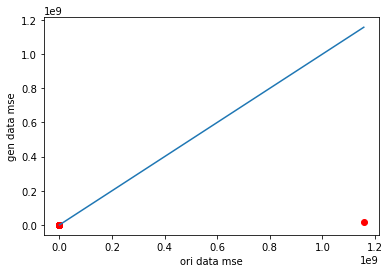

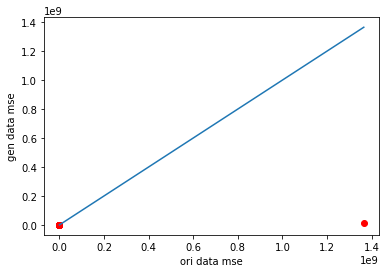

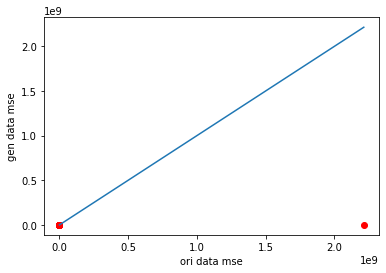

In [84]:
# here have the plots for each predictive model, each dot is a column with ori vs gen
plot_colmse(colmse_t)

### <u> Results cont. </u>
The following table shows the averaged column MSE's from the previous table for each predictive model for the original and synthetic data. These are plotted in the following scatter plot (Figure 2).

In [42]:
com_t = Comparison_Table(synthetic_num_dic, aver=True, models=['LR', 'KNR1'])
display(com_t)
#com_t.to_csv('csv_results/MSE_3_coordinates_figure2.csv')

DoppelGANger_0903                
                   ori             gen
LR    57505242.1723944 1046892.7491443
KNR1  68172077.2806102  701183.2220821

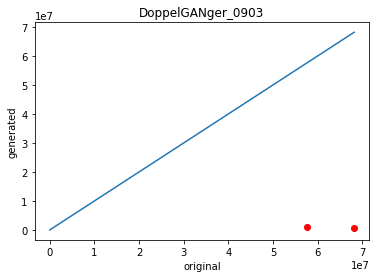

In [43]:
Scatter_TSTS_TRTR(com_t)

In [44]:
get_origen_mse(com_t)

DoppelGANger_0903
avg ori gen MSE 3869933382327463.0000000

### <u> Results cont. </u>
The following table shows the MSE's for all predictive models between the original and the generated data for each model. The table after it shows the average of these MSE's.

In [45]:
avg_modelmse_t = get_avg_mse_per_model(colmse_t)
display(avg_modelmse_t)

DoppelGANger_0903
LR    72078667667603440.0000000
KNR1 101654545341154352.0000000
DTR  271773354831614304.0000000

In [46]:
get_mean_avg_modelmse(avg_modelmse_t)

DoppelGANger_0903
mean model-averaged mse 148502189280124032.0000000

### <u> Results cont. </u>
Table 3 presents the SRA for each column, where the MSE_1's for each predictive model were ranked and compared between original and synthetic data

In [47]:
sra_col_t = get_SRA_per_col(colmse_t)
display(sra_col_t)

DoppelGANger_0903                                                      \
          ab_pain_dur       age aneroxia_dur plasmodium_density cough_dur   
SRA         0.0000000 1.0000000    0.3333333          0.0000000 0.3333333   

                                                                          \
    diarrhea_dur fatigue_dur fever_dur headache_dur    height hemoglobin   
SRA    0.0000000   0.0000000 0.3333333    0.0000000 0.6666667  0.3333333   

                                                                            \
    joint_pain_dur muscle_ache_dur      temp vomit_dur    weight      dday   
SRA      0.0000000       0.0000000 0.3333333 0.3333333 1.0000000 0.6666667   

                
    first_dday  
SRA  0.0000000

### <u> Results cont. </u>
Table 4 displays the SRA value that was calculated using the averaged column MSE's ranking the predictive models for the original and synthetic data.

In [48]:
sra_E = SRA_TSTS_TRTR(com_t)
display(sra_E)

'SRA for E table'

DoppelGANger_0903   0.0000000
dtype: float64

### <u> Conclusions </u>

### Eliminate all the following?

In [18]:
def SRA_Comparison(df_dic,models = ['LR','DTR','SVM','RFR','KNR1','KNR5'] ):
    '''
    The dataframe values are TSTSvsTRTR SRAs which are ranking values for the accuracy of every columns, for the index model which is trained and tested on the column dataset.
    '''
    l = len(df_dic)
    v_np = np.zeros((len(models),l))
    keys = list(df_dic.keys())
    for n in range(l):
        k = keys[n]
        P1 = Prediction(df_dic[k][0])
        P2 = Prediction(df_dic[k][1])
        for m in range(len(models)):
            model = models[m]
            v_np[m][n] = SRA(P1.Evaluation_MSE(model),P2.Evaluation_MSE(model))
    display('SRA for column rankings')
    return pd.DataFrame(v_np,index = models, columns = keys)

In [60]:
sra_c = SRA_Comparison(synthetic_num_dic, models=['LR','KNR1'])
display(sra_c)

'SRA for column rankings'

DoppelGANger_0903
LR             0.843137
KNR1           0.862745

#### V) Epsilon Values Table

In [64]:
def Epsilon_Table(df_dic, models=['LR','DTR','SVM','RFR','KNR1','KNR5'] ):
    '''
    The dataframe values are TSTSvsTRTR Epsilon values for the index model and column generator.
    '''
    
    l = len(df_dic)
    v_np = np.zeros((len(models),l))
    keys = list(df_dic.keys())
    for n in range(l):
        k = keys[n]
        P1 = Prediction(df_dic[k][0])
        P2 = Prediction(df_dic[k][1])
        column_length = len((df_dic[k][0].keys()).tolist())
        for m in range(len(models)):
            model = models[m]
            v_np[m][n] = mean_squared_error(P1.Evaluation_MSE(model),P2.Evaluation_MSE(model))/column_length
    display('Epsilon value table')
    return pd.DataFrame(v_np,index = models, columns = keys)

In [66]:
EpsilonTable = Epsilon_Table(synthetic_num_dic, models=['LR', 'KNR1'])
#EpsilonTable.to_csv('csv_results/3.1 DWP/EpsilonTable.csv')
display(EpsilonTable)

'Epsilon value table'

DoppelGANger_0903
LR         5.591554e+15
KNR1       7.775837e+15

<a id = "tpred_link" Here ></a>

## <font color=#472F91> 3.2 Next-step predictive model performance comparison </font>

### <u> Method description </u>
This method has a similar principal to the previous method with the difference that the predictive model attempts to predict all variables for next time-step entry
    based on the values for previous time-stamps.
    <br>Here the predictive model is x and returns a test metric and a test loss for each column.
    <br>To compare between datasets, two parameters are determined.
    <br>Firstly, the MSE between the test loss/test metric is calculated between the real and the synthetic data for each column.
    <!-- <br><b>A low MSE indicates the predictive model behaves similarly in attempting to predict the next time-step in both datasets</b> -->
    <br>Secondly, the SRA is calculated, ranking the test metric/test loss of each column, comparing the rank for the synthetic and for the original data.
    <br><b>A low MSE and an SRA close to 1 indicates the predictive model behaves similarly in attempting to predict the next time-step in both datasets.</b>

In [70]:
def make_time_windows(dataset, w):
    """replaces each participant's 130 time-steps long timeseries with 
    all possible time series chunks of length w
    Args:
    dataset: 3d numpy array (num sample, max time series length, numerical column dimension) 
            containing only numerical columns from the dataset
    w: window length of time series

    """
    num_participants, full_length, _ = np.shape(dataset)
    time_windows = []

    for i in list(range(num_participants)): # i = participant's position in dataset

        for j in list(range(full_length-w+1)): # j = row number of first row in window
            time_windows.append(dataset[i,j:j+w,:])

    return np.stack(time_windows)


def make_x_y(dataset, y_index, w):
    """make inputs for model. Note the returned data's sequence length = w-1
        
        Args:
        dataset: 3d numpy array (num sample, max time series length, numerical column dimension) 
                containing only numerical columns from the dataset
        y_index: index of column to be treated as the 'label'
        w: window length of time series, should be less than time series length

        Returns:
        x: train data
        y: train label
    """
    dataset = make_time_windows(dataset, w)
    x = np.delete(dataset, obj=y_index, axis=2) # remove y column from all time series
    x = np.delete(x, obj=-1, axis=1) # remove last row from all time series
    y = dataset[:,1:,[y_index]] # take only y column and remove its earliest cell
    return x, y

In [71]:
def last_time_step_mae(Y_true, Y_pred):
    """
    calculates the MAE of the last time step
    """
    return tf.keras.metrics.MAE(Y_true[:, -1], Y_pred[:, -1])

def make_predictive_model(num_cols):
    """
    define architecture of time predictive model
    """
    input_size = [None,num_cols-1] 
    hidden_dim = num_cols//2 #

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=input_size)) # (#timesteps -1, #features=dim-1) 
    model.add(tf.keras.layers.GRU(hidden_dim, return_sequences=True)) # (#timesteps -1, hidden_dim)
    model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(hidden_dim, activation = "sigmoid")))  # (#timesteps -1, hidden_dim)
    model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1, activation = "linear")))  # (#timesteps -1, 1)

    model.compile(optimizer = "adam", loss = tf.keras.losses.MeanAbsoluteError(), metrics=[last_time_step_mae])

    return model

In [72]:
def predictive_train_test(train_set, test_set, y_cols='all', y_cols_name=num_cols, windows='max', val_ratio=0.2, batch_size=64, epochs=15, show_training=True):
    """ does the T_T_ portion of the scheme

    Args:
    - train_set, test_set: ori_data, gen_data in order of T_T_ (labels NOT yet split off), usually output from train_test_split
    Make sure train and test are disjoint!
    If doing TSTSvsTRTR then use this function twice
    - y_cols: list of columns to use as target
    - y_cols_name: the names of ALL the numerical columns
    - windows: list contains lengths of windows to be used in order of y columns
            NOTE length of input sequences is actually window_length - 1 because of make_x_y
    - val_ratio: validation set ratio split from train_set for use during training
    - batch_size
    - epochs

    Returns:
    - results_df: dataframe containing training results
    - histories
    """

    results = []
    histories = []
    _, max_window, num_columns = np.shape(train_set)
    
    #### for convenience when not tuning parameters
    if y_cols=='all':
        y_cols = list(range(num_columns))

    if windows=='max':
        windows=[max_window]*len(y_cols)
    elif isinstance(windows, int):
        windows=[windows]*len(y_cols)

    for k in range(len(y_cols)): # step 5 (repeating steps 2-4 for each column)
        print('\nPredictive model running for column ', str(y_cols_name[k]), ' with window length ', str(windows[k]))
        train_x, train_y = make_x_y(train_set, y_cols[k], windows[k]) # step 2
        test_x, test_y = make_x_y(test_set, y_cols[k], windows[k])
        train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=val_ratio)

        model = make_predictive_model(num_columns)
        hist = model.fit(np.asarray(train_x), np.asarray(train_y), batch_size=batch_size, epochs=epochs, validation_data=(val_x, val_y), verbose=0) # step 4
        print('Getting results for column ', str(y_cols_name[k]), ' with window length ', str(windows[k]))

        results.append([y_cols_name[k], windows[k], batch_size, epochs]+model.evaluate(test_x, test_y, batch_size=batch_size))
        histories.append(hist)

        if show_training:
            plt.plot(hist.history['loss'])
            plt.plot(hist.history['val_loss'])
            plt.title('model loss')
            plt.ylabel('loss')
            plt.xlabel('epoch')
            plt.legend(['train loss', 'val loss'], loc='upper right')
            plt.show()

    results_df = pd.DataFrame(results, columns=['y_col', 'window_length', 'batch_size', 'epochs', 'test_loss', 'test_metric'])

    return results_df, histories
        


In [94]:
def get_TxTx_tpred_results(ori_3d_num, gen_3d_num, y_cols='all', y_cols_name=num_cols, windows='max', val_ratio=0.2, batch_size=64, epochs=15, show_training=True):
    """
    computes TRTR TSTS test loss and metrics loss for each column specified
    works for only one version of data generated as it expects numpy arrays for ori_3d_num and gen_3d_num

    Args:
    ori_3d_num: 3d numpy array of numerical columns in original data
    gen_3d_num: 3d numpy array of numerical columns in generated data

    Returns:
    TRTR_TSTS_combine: dataframe with test loss and test metrics for TRTR and TSTS 
    """
    train_ori_set, test_ori_set = train_test_split(ori_3d_num, train_size=0.5)
    TRTR_results, TRTR_histories = predictive_train_test(train_ori_set, test_ori_set, y_cols=y_cols, windows=windows, epochs=epochs, show_training=show_training)

    train_gen_set, test_gen_set = train_test_split(gen_3d_num, train_size=0.5)
    TSTS_results, TSTS_histories = predictive_train_test(train_gen_set, test_gen_set, y_cols=y_cols, windows=windows, epochs=epochs, show_training=show_training)

    TRTR_TSTS_combine = pd.merge(TRTR_results[['y_col', 'test_loss', 'test_metric']], TSTS_results[['y_col','test_loss', 'test_metric']], on='y_col')
    TRTR_TSTS_combine.columns = ['y_col', 'test_loss_trtr', 'test_metric_trtr', 'test_loss_tsts', 'test_metric_tsts']

    return TRTR_TSTS_combine

In [74]:
def TxTx_tpred_multiple(df_dic, y_cols='all', y_cols_name=num_cols, windows='max', val_ratio=0.2, batch_size=64, epochs=15, show_training=True):  
    """
    computes get_TxTx_tpred_results for multiple version of generated data since it expects a dictionary of data as input
    Concatenates results of multiple versions of data into a dataframe

    Args:
    df_dic: dictionary with key as data version and value as (ori_3d_num, gen_3d_num)
    """ 
    l = len(df_dic)
    keys = list(df_dic.keys())

    #for multi indexing
    keys_index = []
    for k in keys:
        keys_index += [k]* 5
    d = None

    for i in range(l):
            k = df_dic[keys[i]]
            ori_3d = k[0]
            gen_3d = k[1]
            d_txtx = get_TxTx_tpred_results(ori_3d, gen_3d, y_cols=y_cols, y_cols_name=y_cols_name, windows=windows, epochs=epochs, show_training=show_training)
            if d is None:
                d = d_txtx
            else:
                d = pd.concat([d, d_txtx], axis=1)
    #multi indexing for columns
    cols = d_txtx.columns.to_list()
    multi_array = np.array([keys_index,cols * l])
    col_multi = pd.MultiIndex.from_arrays(multi_array)
    d.columns = col_multi

    return d

In [104]:
def plot_TxTx_tpred(TxTx_tpred):

    """
    Plots TRTR test loss/metric against TSTS. Ideally the points should lie on the diagonal

    Args:
    TxTx_tpred: dataframe containing the test loss/ metric for each numerical column, usually output from TxTx_tpred_multiple func
    """

    versions = TxTx_tpred.columns.unique(level=0).to_list()

    for i in range(len(versions)):
            orid = TxTx_tpred[versions[i], 'test_loss_trtr']
            gend = TxTx_tpred[versions[i], 'test_loss_tsts']
            plt.scatter(orid, gend, c='r')
            plt.plot([0, max(orid)], (0, max(orid)))
            plt.xlabel('TRTR test loss')
            plt.ylabel('TSTS test loss')
            plt.show()

            orid = TxTx_tpred[versions[i], 'test_metric_trtr']
            gend = TxTx_tpred[versions[i], 'test_metric_tsts']
            plt.scatter(orid, gend, c='r')
            plt.plot([0, max(orid)], (0, max(orid)))
            plt.xlabel('TRTR test metric')
            plt.ylabel('TSTS test metric')
            plt.show()

In [107]:
def get_TxTx_mse(TxTx_tpred):
    """
    gets the MSE over the columns for TRTR TSTS

    Args:
    TxTx_tpred: dataframe containing the test loss/ metric for each numerical column, usually output from TxTx_tpred_multiple func

    Returns:
    TxTx_tpred_mse: dataframe with TRTR TSTS mse
    """
    
    versions = TxTx_tpred.columns.unique(level=0).to_list()
    
    v_index = []
    for v in versions:
        v_index += [v] * 2
    t_index = ['test_loss', 'metric_loss'] * len(versions)
    col_multi_index = np.array([v_index, t_index])
    col_multi_index = pd.MultiIndex.from_arrays(col_multi_index)

    mse = []
    for i in range(len(versions)):
        test_mse = mean_squared_error(TxTx_tpred[versions[i], 'test_loss_trtr'], TxTx_tpred[versions[i], 'test_loss_tsts'])
        metric_mse = mean_squared_error(TxTx_tpred[versions[i], 'test_metric_trtr'], TxTx_tpred[versions[i], 'test_metric_tsts'])
        mse.append(test_mse)
        mse.append(metric_mse)
    mse = np.array(mse).reshape((-1, len(mse)))
    TxTx_tpred_mse = pd.DataFrame(mse, columns=col_multi_index, index=['trtr tsts MSE'])
    return TxTx_tpred_mse

In [105]:
def get_TxTx_SRA(TxTx_tpred):
    """
    compares numerical column between TRTR and TSTS to get SRA value

    Args: 
    TxTx_tpred: dataframe containing the test loss/ metric for each numerical column, usually output from TxTx_tpred_multiple func

    Returns:
    TxTx_tpred_sra: dataframe with SRA values for test loss/metric
    """

    versions = TxTx_tpred.columns.unique(level=0).to_list()
    
    v_index = []
    for v in versions:
        v_index += [v] * 2
    t_index = ['test_loss', 'metric_loss'] * len(versions)
    col_multi_index = np.array([v_index, t_index])
    col_multi_index = pd.MultiIndex.from_arrays(col_multi_index)

    sra = []
    for i in range(len(versions)):
        test_SRA = SRA(TxTx_tpred[versions[i], 'test_loss_trtr'], TxTx_tpred[versions[i], 'test_loss_tsts'])
        metric_SRA = SRA(TxTx_tpred[versions[i], 'test_metric_trtr'], TxTx_tpred[versions[i], 'test_metric_tsts'])
        sra.append(test_SRA)
        sra.append(metric_SRA)
    sra = np.array(sra).reshape((-1, len(sra)))
    TxTx_tpred_sra = pd.DataFrame(sra, columns=col_multi_index, index=['SRA'])
    return TxTx_tpred_sra

### <u> Results </u>
The following table gives a report on the test metric and test loss for each column when trained with 65 windows for 2 epochs. 
<br> The scatter plots display the test metric or the test loss for the original data (x axis) and generated data (y axis) for each predicted column.
<br> Finally, the MSE of the test metric and the test loss for all columns is calculated between the original and the generated data. In parallel, the SRA is also calculated, where the test metric or test loss for each column is ranked and compared between the original and the generated data.

In [96]:
TxTx_tpred = TxTx_tpred_multiple(synthetic_array_num_dic, y_cols=[0,1,2], y_cols_name=num_cols[:3], windows=65, epochs=1, show_training=False)
#TxTx_tpred.to_csv('csv_results/t_Predictive_coordinates.csv')
TxTx_tpred


Predictive model running for column  ab_pain_dur  with window length  65
Getting results for column  ab_pain_dur  with window length  65
696/696 [==============================] - 5s 7ms/step - loss: 0.0353 - last_time_step_mae: 0.0055

Predictive model running for column  age  with window length  65
Getting results for column  age  with window length  65
696/696 [==============================] - 6s 9ms/step - loss: 2.2590 - last_time_step_mae: 0.3269

Predictive model running for column  aneroxia_dur  with window length  65
Getting results for column  aneroxia_dur  with window length  65
696/696 [==============================] - 6s 9ms/step - loss: 0.0167 - last_time_step_mae: 0.0022

Predictive model running for column  ab_pain_dur  with window length  65
Getting results for column  ab_pain_dur  with window length  65
696/696 [==============================] - 5s 7ms/step - loss: 0.1397 - last_time_step_mae: 0.0152

Predictive model running for column  age  with window length  65


DoppelGANger_0903                                                 \
              y_col test_loss_trtr test_metric_trtr test_loss_tsts   
0       ab_pain_dur      0.0352722        0.0054524      0.1397303   
1               age      2.2590492        0.3269033      1.8777696   
2      aneroxia_dur      0.0166908        0.0022197      0.0920007   

                    
  test_metric_tsts  
0        0.0151984  
1        0.2711462  
2        0.0104184

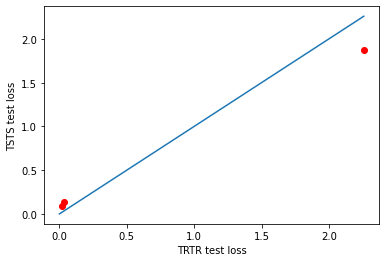

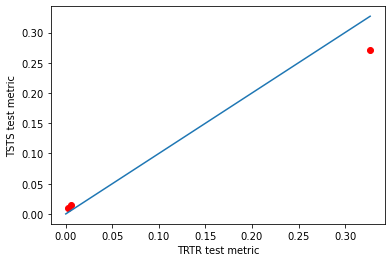

In [103]:
plot_TxTx_tpred(TxTx_tpred)

In [108]:
TxTx_tpred_mse = get_TxTx_mse(TxTx_tpred)
TxTx_tpred_mse

DoppelGANger_0903            
                      test_loss metric_loss
trtr tsts MSE         0.0539857   0.0010904

In [106]:
TxTx_tpred_sra = get_TxTx_SRA(TxTx_tpred)
TxTx_tpred_sra

DoppelGANger_0903            
            test_loss metric_loss
SRA         1.0000000   1.0000000